# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

## The Assignment ##
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

## Solution

### Packages Used

In [10]:
from PIL import Image
import pytesseract
import cv2 as cv
import numpy as np
from zipfile import ZipFile
from IPython.display import display

# loading the face detection classifier
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')

# the rest is up to you!

### Custom Functions

This section contains the custom functions and their definitions

#### File names

This is a routine function which is used to extract file names from zip folder

In [11]:
bigfile = 'readonly/images.zip' 
#smallfile = 'readonly/small_img.zip'

# Returns a list of the file names inside the bigfile
def get_file_names_from_zip(bigfile):    
    with ZipFile(bigfile, 'r') as archive:         
        imglist = archive.namelist()
        #print('imagelist:',imglist)
        return imglist

#### Getting Images
This is a routine function to extract images from zip folder

In [12]:
def get_images_from_zip(bigfile, name, pxsize):     
    with ZipFile(bigfile, 'r') as archive:        
        with archive.open(name) as file:            
            with Image.open(file) as img:                
                if pxsize:                    
                    image = img.resize((pxsize, (pxsize*img.height//img.width )),                    
                                       resample=Image.BICUBIC)                
                else:                    
                    image = img    
                return image.convert('RGB')

#### Data Dictionary
This is a routine function to create a data dictionary with following keys: {the filename (e.g.: 'a-0.png'): {'image': a Pil image, 'text': the Tesserac t text}}

In [13]:
def create_data_dict(bigfile, pxsize=None):    
    data = {}    
    imglist = get_file_names_from_zip(bigfile)
    print('Imagelist:',imglist)
    for img in imglist:
        print('img:',img)
        image = get_images_from_zip(bigfile, img, pxsize)        
        text = pytesseract.image_to_string(image)        
        if img not in data:            
            data.setdefault(img, {'image': image, 'text': text}) 
        #print(data)    
    return data

#### Word search
This is a routine function to search for the provided word in the provided text

In [14]:
def search_word_in_text(text, word):    
    return word.upper() in text.upper()

#### Contact Sheet
This is a routine function to make contact sheet

In [15]:
# create a contact sheet layer
def contact_sheet_layer(imglist, cols, cells):    
    val = (0 if len(imglist) % cols == 0 else 1)    
    return Image.new('RGB',(cells[0]*cols, cells[1]*((len(imglist) // cols) + val)))

# Creates the contact sheet # The optional parameters are the number of colums and the thumbnail size 
def create_contact_sheet(imglist, cols=5, cells=(150, 150)):    
    print("{} images to add to contact sheet...".format(len(imglist)))    
    contact_sheet = contact_sheet_layer(imglist, cols, cells)    
    x = 0    
    y = 0    
    for img in imglist:        
        image = Image.fromarray(img)
        #display(image)
        thumb = image.resize((cells[0], (cells[0]*image.height//image.width)))
        contact_sheet.paste(thumb, (x, y))        
        if x + thumb.width == contact_sheet.width:            
            x = 0            
            y += cells[1]        
        else:            
                x += thumb.width    
    return contact_sheet

#### Detect faces
This is a routine function to detect and return cropped faces from the image

In [16]:
def detect_faces(image, scale, minN, minS, maxS):    
   cvimage = cv.cvtColor(np.array(image), cv.COLOR_RGB2BGR)    
   faces = face_cascade.detectMultiScale(cvimage,    
                                        scaleFactor=scale,    
                                        minNeighbors=minN,    
                                        minSize=(minS, minS),    
                                        maxSize=(maxS, maxS))    
   cropimages = []    
   for (x, y, w, h) in faces:        
      cv.rectangle(cvimage, (x, y), (x + w, y + h), (0, 0, 0), 1)        
      rgb = cv.cvtColor(cvimage, cv.COLOR_BGR2RGB)        
      cropimages.append(rgb[y:y + h, x:x + w])    
   return cropimages

#### Image Search
This is a routine function to search for images from the provided text

In [17]:
def find_word_faces(data_dict, word, scale, minN, minS, maxS):
    print(data_dict.keys())
    for key in data_dict.keys():        
        if search_word_in_text(data_dict[key]['text'], word):            
            images = detect_faces(data_dict[key]['image'], scale, minN, minS,maxS)            
            print("Results found in file " + key)            
            if images:                
                display(create_contact_sheet(images))            
            else:                
                print("But there were no faces in that file!")

### Testing the program

In [18]:
datatest = create_data_dict(bigfile)
wordtest = "Christopher" 



datafinal = create_data_dict(bigfile)
wordfinal = "Mark"

Imagelist: ['a-0.png', 'a-1.png', 'a-10.png', 'a-11.png', 'a-12.png', 'a-13.png', 'a-2.png', 'a-3.png', 'a-4.png', 'a-5.png', 'a-6.png', 'a-7.png', 'a-8.png', 'a-9.png']
img: a-0.png
img: a-1.png
img: a-10.png
img: a-11.png
img: a-12.png
img: a-13.png
img: a-2.png
img: a-3.png
img: a-4.png
img: a-5.png
img: a-6.png
img: a-7.png
img: a-8.png
img: a-9.png
Imagelist: ['a-0.png', 'a-1.png', 'a-10.png', 'a-11.png', 'a-12.png', 'a-13.png', 'a-2.png', 'a-3.png', 'a-4.png', 'a-5.png', 'a-6.png', 'a-7.png', 'a-8.png', 'a-9.png']
img: a-0.png
img: a-1.png
img: a-10.png
img: a-11.png
img: a-12.png
img: a-13.png
img: a-2.png
img: a-3.png
img: a-4.png
img: a-5.png
img: a-6.png
img: a-7.png
img: a-8.png
img: a-9.png


dict_keys(['a-0.png', 'a-1.png', 'a-10.png', 'a-11.png', 'a-12.png', 'a-13.png', 'a-2.png', 'a-3.png', 'a-4.png', 'a-5.png', 'a-6.png', 'a-7.png', 'a-8.png', 'a-9.png'])
Results found in file a-0.png
7 images to add to contact sheet...


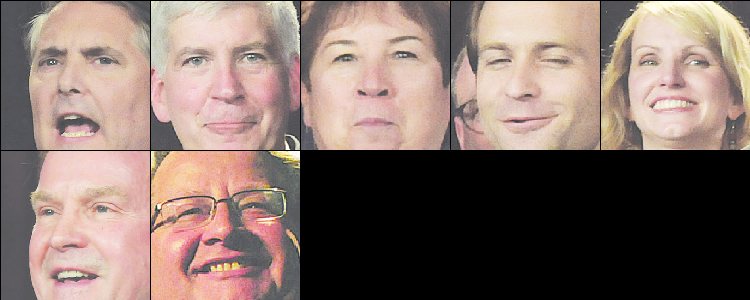

Results found in file a-1.png
7 images to add to contact sheet...


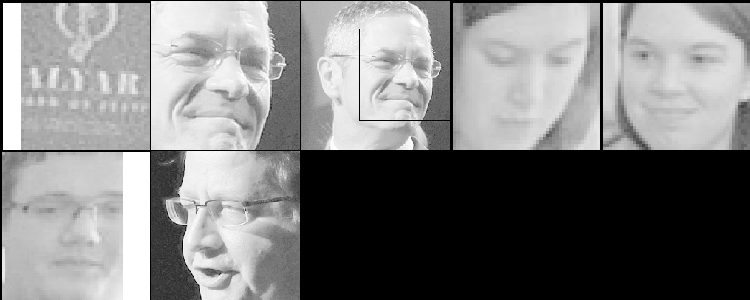

Results found in file a-10.png
But there were no faces in that file!
Results found in file a-13.png
6 images to add to contact sheet...


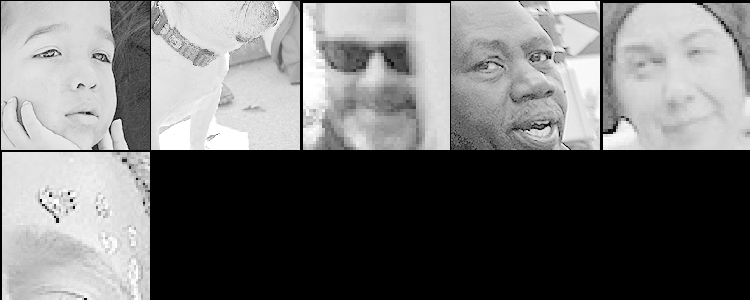

Results found in file a-2.png
2 images to add to contact sheet...


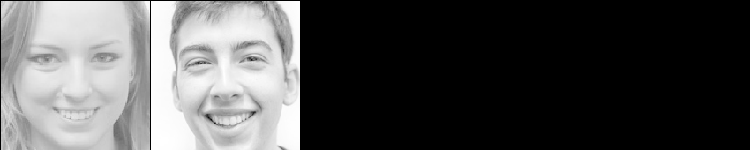

Results found in file a-3.png
2 images to add to contact sheet...


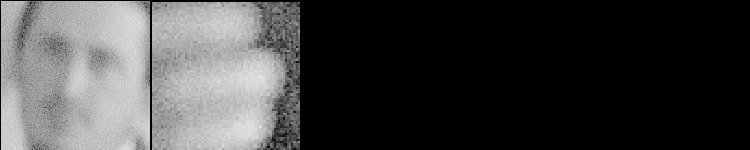

Results found in file a-5.png
6 images to add to contact sheet...


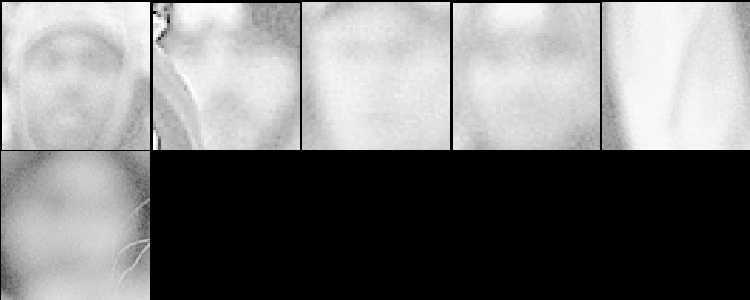

Results found in file a-8.png
1 images to add to contact sheet...


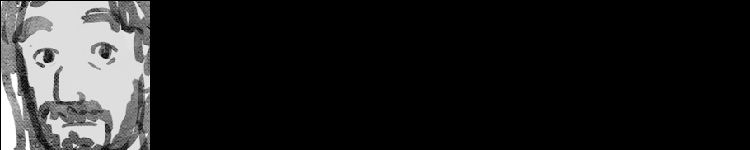

Results found in file a-9.png
But there were no faces in that file!


In [19]:
#find_word_faces(datatest, wordtest, 1.20, 5, 35, 370)
find_word_faces(datafinal, wordfinal, 1.20,5, 35, 370)